# Load Data and Preprocessing

In [15]:
import pandas as pd
import os
import plotly.graph_objects as go
import numpy as np
import matplotlib.pyplot as plt

# Set the default DPI
plt.rcParams['figure.dpi'] = 100  

well_info = pd.read_csv('well-loc.tsv', sep='\t')

# Path to the sensor data directory
sensor_data_path = 'sensor-data'

# List all TSV files in the directory
sensor_data_files = [f for f in os.listdir(sensor_data_path) if f.endswith('.tsv')]

# Sort the sensor_data_files list
sensor_data_files.sort(key= lambda x: int(x.split('.')[0]))

# Load and concatenate all sensor data files into one DataFrame
sensor_data_list = [pd.read_csv(os.path.join(sensor_data_path, file), sep='\t',
                                na_values="-9999") for file in sensor_data_files]

# Remove the data point with NaN value
well_info = well_info.dropna()
for sensor_data in sensor_data_list:
    sensor_data.dropna(inplace=True)

# Reset the index of the well_loc DataFrame to Well, X, Y
well_info.rename(columns={'井': 'Well'}, inplace=True)

# Reset the index of the sensor data DataFrame to Depth, Porosity, Hydrate Saturation
for idx, _ in enumerate(sensor_data_list):
	sensor_data_list[idx].columns = ['Depth', 'Porosity', 'Hydrate Saturation']

print(well_info.head())  # Display the first few rows to verify it's loaded correctly
print(sensor_data_list[0].head())  # Display the first few rows to verify it's loaded correctly

  Well      X      Y
0  w01  34500  45000
1  w02  36000  45050
2  w03  37050  45020
3  w04  37880  46000
4  w05  35000  46030
         Depth  Porosity  Hydrate Saturation
112  1832.0004    0.5236              0.0237
113  1832.1528    0.5208              0.0175
114  1832.3052    0.5196              0.0000
115  1832.4576    0.5156              0.0000
116  1832.6100    0.4971              0.0000


In [16]:
from sklearn.preprocessing import MinMaxScaler

# Normalize the sensor data
scaler = MinMaxScaler()
for idx, sensor_data in enumerate(sensor_data_list):
    sensor_data[['Porosity', 'Hydrate Saturation']] = scaler.fit_transform(sensor_data[['Porosity', 'Hydrate Saturation']])

# Estimate Resource Distribution

In [17]:
def estimate_resource(sensor_data: pd.Series) -> float:
	"""Estimate the resource at a given location based on sensor data"""
	# Get the Porosity and the Hydrate saturation
	porosity = sensor_data['Porosity']
	hydrate_saturation = sensor_data['Hydrate Saturation']

	valid_volume = 1 # Assume the valid volume is 1 cubic meter
	factor = 155 # Assume the factor is 155

	# Calculate the resource estimate
	return valid_volume * porosity * hydrate_saturation * factor

In [18]:
# Calculate the resource estimate for each sensor data in each depth
for idx, sensor_data in enumerate(sensor_data_list):
    sensor_data_list[idx]['Estimated Resources'] = sensor_data.apply(estimate_resource, axis=1)

sensor_data_list[0]

,Depth,Porosity,Hydrate Saturation,Estimated Resources
112,1832.0004,0.619070,0.266592,25.581030
113,1832.1528,0.605918,0.196850,18.487664
114,1832.3052,0.600282,0.000000,0.000000
115,1832.4576,0.581494,0.000000,0.000000
116,1832.6100,0.494598,0.000000,0.000000
...,...,...,...,...
1716,2076.4500,0.268201,0.000000,0.000000
1717,2076.6024,0.393612,0.000000,0.000000
1718,2076.7548,0.337248,0.000000,0.000000
1719,2076.9072,0.357915,0.000000,0.000000


In [19]:
resource_sums = [df['Estimated Resources'].sum() for df in sensor_data_list]
well_info['Total Resources'] = resource_sums

# Kriging 2D Interpolation

### Kriging Interpolation of Total Resources

14


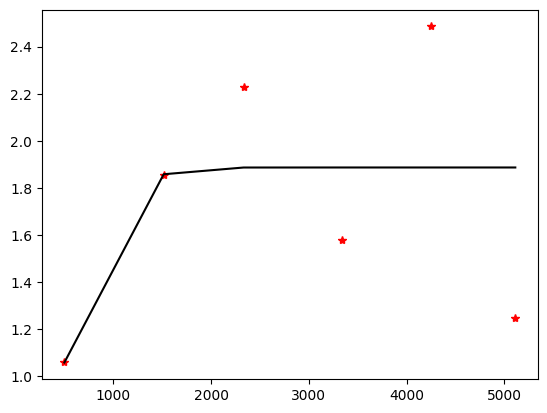

In [20]:
from pykrige.ok import OrdinaryKriging

# 假设 well_info 是一个包含井点信息的DataFrame，其中包含X坐标、Y坐标和资源总量
X = well_info['X']
Y = well_info['Y']
values = np.log(well_info['Total Resources'])

print(len(values))

# 创建OrdinaryKriging对象，这里只是为了生成实验变异函数
ok = OrdinaryKriging(
    X,
    Y,
    values,
    variogram_model='gaussian',
    enable_plotting=True
)

In [21]:
# Define grid points for interpolation
grid_x = np.arange(min(X)-200, max(X)+200, 1.0)
grid_y = np.arange(min(Y)-200, max(Y)+200, 1.0)

# Perform the interpolation
z, ss = ok.execute('grid', grid_x, grid_y)

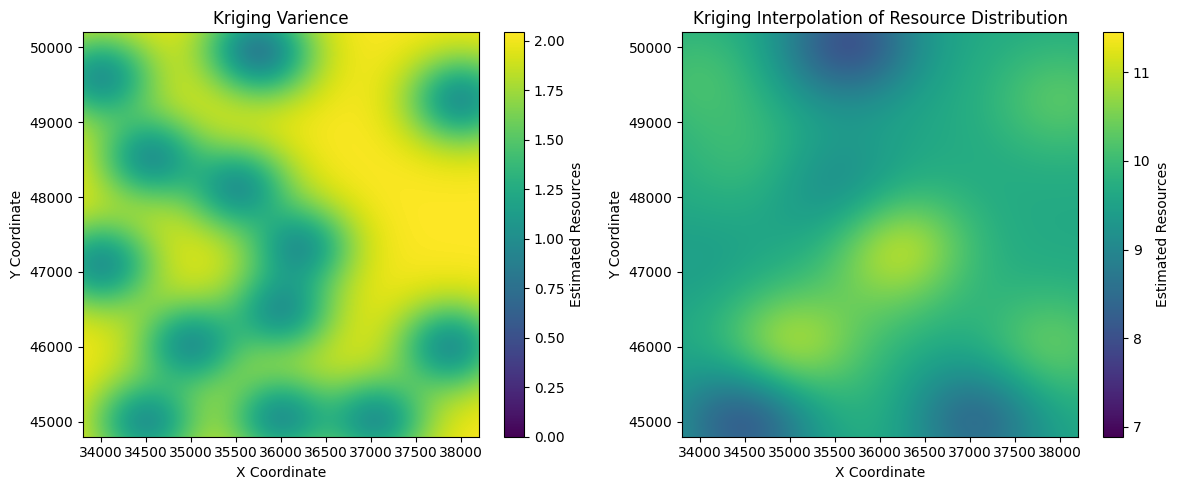

In [ ]:
# Create a figure with two subplots
fig, axs = plt.subplots(1, 2, figsize=(12, 5))  # 1 row, 2 columns

# Plot the first kriging result on the first subplot
c1 = axs[0].pcolormesh(grid_x, grid_y, ss, shading='auto')
fig.colorbar(c1, ax=axs[0], label='Estimated Resources')
axs[0].set_xlabel('X Coordinate')
axs[0].set_ylabel('Y Coordinate')
axs[0].set_title('Kriging Varience')

# Plot the second kriging result on the second subplot
c2 = axs[1].pcolormesh(grid_x, grid_y, z, shading='auto')
fig.colorbar(c2, ax=axs[1], label='Estimated Resources')
axs[1].set_xlabel('X Coordinate')
axs[1].set_ylabel('Y Coordinate')
axs[1].set_title('Kriging Interpolation of Resource Distribution')

# Show the plot
plt.tight_layout()
plt.show()